## In this notebook we study the following single species coagulation reaction with sopantaneous creation and destruction:

\begin{equation}
    A \leftrightharpoons_{k_2}^{k_1} \emptyset    
\end{equation}

\begin{equation}
    A + A\rightarrow^{k_3} A    
\end{equation}

## Starting from Poisson initial conditions. 

## We numerically solve the Chemical Master Equation by bouding the state space.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys

sys.path.append('../')
sys.path.append('../src')

from src import cheMASTER


## Setting up the reaction stoichiometry, rates and initial conditions

In [2]:
# Setting up the reactions and the parameters:

#Number of species in the reaction system
num_species     = 1 

#Number of interating reactions in the Hamiltonian
num_interaction = 1 

#This counts the total number of possible reactions in the system.
#We have 2N creation and destruction reactions and the rest interaction reactions
num_reactions   = 2*num_species + num_interaction 

# Rate constants for the reaction system: [k1 is Creation and k2 is Destruction]
k1 = np.array([1.]) #len must be equal to num_species
k2 = np.array([1.]) #len must be equal to num_species

# Interaction reactions:
k3 = np.array([1.]) #len must be equal to num_interactions    

#Defining the stoichiometry for the reactions
s_i,r_i = np.zeros([num_interaction,num_species]),np.zeros([num_interaction,num_species])

#Write this for all reactions in the interacting Hamiltonian corresponding to the reaction rate k3
s_i[0] = [1] 
r_i[0] = [2]

rxn_par = [k1,k2,k3]

#The initial mean concentration of the species
initial_values = 4./3.


### Define simulation times

In [3]:
tstart = 0.
tfinal = 2.
tstep = 0.02

### Define the cheMASTER class using this data

In [4]:
system = cheMASTER.chemical_system_class(num_interaction,num_species,rxn_par,r_i,s_i)

### Find the steady state means using the top Eigenvalue of the master operator:

In [5]:
cheMASTER.SteadyState_masterOP(system,max_num=[20]);
system.ss_masterOP

array([0.69777466])

### Use the event drive Monte Carlo aka the Gillespie algorithm:

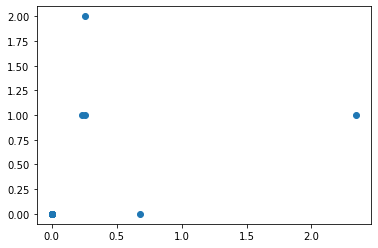

In [6]:
max_timesteps = 10000
time, y = cheMASTER.gillespie(system,initial_values,max_timesteps,tfinal,initialization='poisson')
plt.plot(time,y[0],'o')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1600.83it/s]


Text(0, 0.5, 'mean')

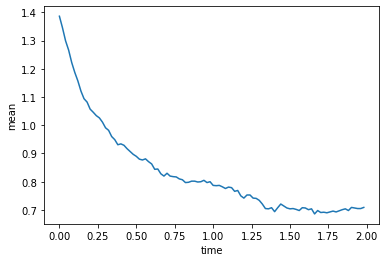

In [8]:
num_repeats = 1000
cheMASTER.gillespie_avg(system,num_repeats,initial_values,0,tfinal,tstep,max_timesteps)
plt.plot(system.timeGrid,system.y[0])
plt.xlabel('time')
plt.ylabel('mean')

### Solve the system using the simple RK4 algorithm:

In [20]:
cheMASTER.initialize_dynamics(system,initial_values,tstart,tfinal,tstep)
cheMASTER.runDynamics(system,max_num=[20],method = "RK4",variance=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 6937.55it/s]


Text(0, 0.5, 'variance')

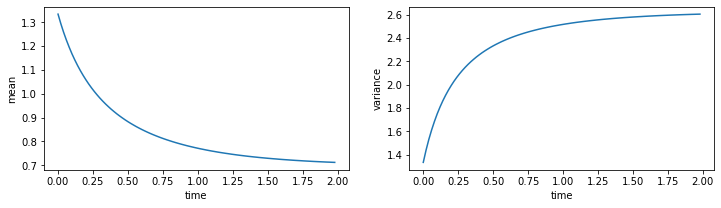

In [21]:
plt.figure(figsize=(12,3))
plt.subplot(121)
plt.plot(system.timeGrid,system.y[0])
plt.xlabel('time')
plt.ylabel('mean')

plt.subplot(122)
plt.plot(system.timeGrid,system.variance[0])
plt.xlabel('time')
plt.ylabel('variance')

### Solve using the Eigenvalue time propagation by diagonalizing the master operator. Also measure the two time connected number correlator

In [48]:
cheMASTER.initialize_dynamics(system,initial_values,tstart,tfinal,tstep)
cheMASTER.runDynamics(system,max_num=[20],method = "Eigenvalue",selfCorrelator_tau=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 318.87it/s]


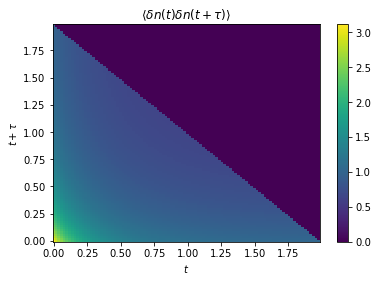

In [49]:
plt.pcolor(system.timeGrid,system.timeGrid,system.correlator_tau[0])
plt.title(r'$\langle \delta n(t) \delta n(t+\tau) \rangle$')
plt.xlabel(r'$t$')
plt.ylabel(r'$t+\tau$')
plt.colorbar()

### Solve using the Euler algorithm and measuring the Response function by changing the perturbation rate to 1.1 times the original, for one time step (need smaller time steps for Euler):

In [45]:
cheMASTER.initialize_dynamics(system,initial_values,tstart,tfinal,0.1*tstep)
cheMASTER.runDynamics(system,max_num=[20],method = "Euler",measureResponse='finite',measureResponse_par=[1.1,1])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 41.54it/s]


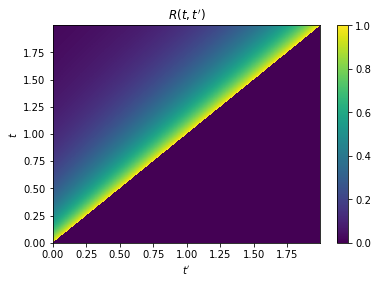

In [47]:
plt.pcolor(system.timeGrid,system.timeGrid,system.Response[0])
plt.title(r'$R(t,t^\prime)$')
plt.ylabel(r'$t$')
plt.xlabel(r'$t^\prime$')
plt.colorbar()